# Part 3 — Single-Sweep vs Continuous-Sweep Mode Comparison

**Assignment:** LibreVNA Validation Test — Part 3

## Objectives
- **(a) Head-to-head timing comparison** across seven IFBW values (150 / 125 / 100 / 75 / 50 / 10 / 1 kHz) for single-sweep mode (ACQ:RUN trigger + ACQ:FIN? poll) and continuous-sweep mode (streaming callback on port 19001).
- **(b) Measurement-quality comparison** — mean S11 trace, per-point jitter, and noise floor between the two modes at every IFBW.
- **(c) 25 Hz target assessment** — determine which mode (if either) reaches the 25 Hz update-rate target at any IFBW, and identify the remaining gap.

## Device under test
| Field | Value |
|---|---|
| Device | LibreVNA |
| Serial | 206830535532 |
| Firmware | v1.6.4 |
| Calibration | SOLT_1 (2.43–2.45 GHz, 300 pts) |
| DUT on Port 1 | Calibrated 50 Ω termination load |

## Notebook workflow
1. **Cell 2** – Imports, path setup, library-version printout
2. **Cell 3** – Load both xlsx workbooks; read and print the Summary sheets
3. **Cell 4** – Sweep-time comparison: mean time with min/max error bands, per mode
4. **Cell 5** – Update-rate grouped bar chart (single vs continuous) with 25 Hz target line
5. **Cell 6** – Mean S11 overlay plots (one panel per mode, colour-mapped across IFBWs)
6. **Cell 7** – Jitter analysis: per-point jitter curves + mean-jitter grouped bars
7. **Cell 8** – Summary comparison tables (PrettyTable): timing, ratios, jitter
8. **Cell 9** – Conclusions

In [1]:
# ---------------------------------------------------------------------------
# Cell 2  --  Imports and path setup
# ---------------------------------------------------------------------------
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
from prettytable import PrettyTable

# ---------------------------------------------------------------------------
# Absolute paths – input workbooks
# ---------------------------------------------------------------------------
BASE   = "/home/user/jeffrymahbuubi/PROJECTS/7-LibreVNA-Vector-Network-Analyzer"
DATA_DIR = os.path.join(BASE, "code", "LibreVNA-dev", "data", "20260205")

SINGLE_XLSX     = os.path.join(DATA_DIR, "single_sweep_test_20260205_225940.xlsx")
CONTINUOUS_XLSX = os.path.join(DATA_DIR, "continuous_sweep_test_20260205_230028.xlsx")

# ---------------------------------------------------------------------------
# IFBW values swept (high → low, kHz)  –  used as the canonical ordering
# throughout the notebook
# ---------------------------------------------------------------------------
IFBW_KHZS = [150, 125, 100, 75, 50, 10, 1]   # int kHz

# ---------------------------------------------------------------------------
# Dark-background colour palette (matches notebook 2)
# ---------------------------------------------------------------------------
COLOR_GOLD   = "#FFD700"   # single-mode accent
COLOR_CYAN   = "#00E5FF"   # continuous-mode accent
COLOR_GREEN  = "#76FF03"
COLOR_RED    = "#FF3333"   # reference / target lines

# Perceptually-uniform colourmap for the 7 IFBWs
CMAP         = plt.cm.plasma
IFBW_COLORS  = [CMAP(i / (len(IFBW_KHZS) - 1)) for i in range(len(IFBW_KHZS))]

# ---------------------------------------------------------------------------
# Version printout
# ---------------------------------------------------------------------------
print(f"SINGLE_XLSX     : {SINGLE_XLSX}")
print(f"CONTINUOUS_XLSX : {CONTINUOUS_XLSX}")
print(f"numpy           : {np.__version__}")
print(f"matplotlib      : {plt.matplotlib.__version__}")
print(f"pandas          : {pd.__version__}")
print(f"openpyxl        : {openpyxl.__version__}")

SINGLE_XLSX     : /home/user/jeffrymahbuubi/PROJECTS/7-LibreVNA-Vector-Network-Analyzer/code/LibreVNA-dev/data/20260205/single_sweep_test_20260205_225940.xlsx
CONTINUOUS_XLSX : /home/user/jeffrymahbuubi/PROJECTS/7-LibreVNA-Vector-Network-Analyzer/code/LibreVNA-dev/data/20260205/continuous_sweep_test_20260205_230028.xlsx
numpy           : 2.2.6
matplotlib      : 3.10.8
pandas          : 2.3.3
openpyxl        : 3.1.5


In [2]:
# ---------------------------------------------------------------------------
# Cell 3  --  Load both xlsx workbooks; read Summary sheets into DataFrames
# ---------------------------------------------------------------------------

# --- helper: read a Summary sheet into a tidy DataFrame --------------------
def _read_summary(path: str) -> pd.DataFrame:
    """Read the Summary sheet from a script-6 workbook.

    Row layout (1-indexed):
        1  – title string
        2  – blank
        3  – column headers
        4+ – data (one row per IFBW)
    """
    df = pd.read_excel(path, sheet_name="Summary", header=2, engine="openpyxl")
    # Strip any trailing whitespace from column names
    df.columns = [str(c).strip() for c in df.columns]
    return df

df_single     = _read_summary(SINGLE_XLSX)
df_continuous = _read_summary(CONTINUOUS_XLSX)

print("=" * 70)
print("SINGLE-MODE  Summary")
print("=" * 70)
print(df_single.to_string(index=False))
print()
print("=" * 70)
print("CONTINUOUS-MODE  Summary")
print("=" * 70)
print(df_continuous.to_string(index=False))

SINGLE-MODE  Summary
  Mode  IFBW (kHz)  Mean Time (s)  Mean Time (ms)  Std Dev (s)  Min Time (s)  Max Time (s)  Rate (Hz)  Noise Floor (dB)  Trace Jitter (dB)
single         150         0.1958        195.8222       0.0092        0.1938        0.2447       5.11            -50.30               1.56
single         125         0.1945        194.5385       0.0008        0.1938        0.1962       5.14            -50.50               1.57
single         100         0.1948        194.8074       0.0009        0.1939        0.1968       5.13            -50.57               1.58
single          75         0.1948        194.8208       0.0009        0.1939        0.1961       5.13            -50.63               1.60
single          50         0.1941        194.1034       0.0005        0.1939        0.1959       5.15            -50.59               1.58
single          10         0.2450        245.0162       0.0004        0.2449        0.2469       4.08            -50.46               1.01
single

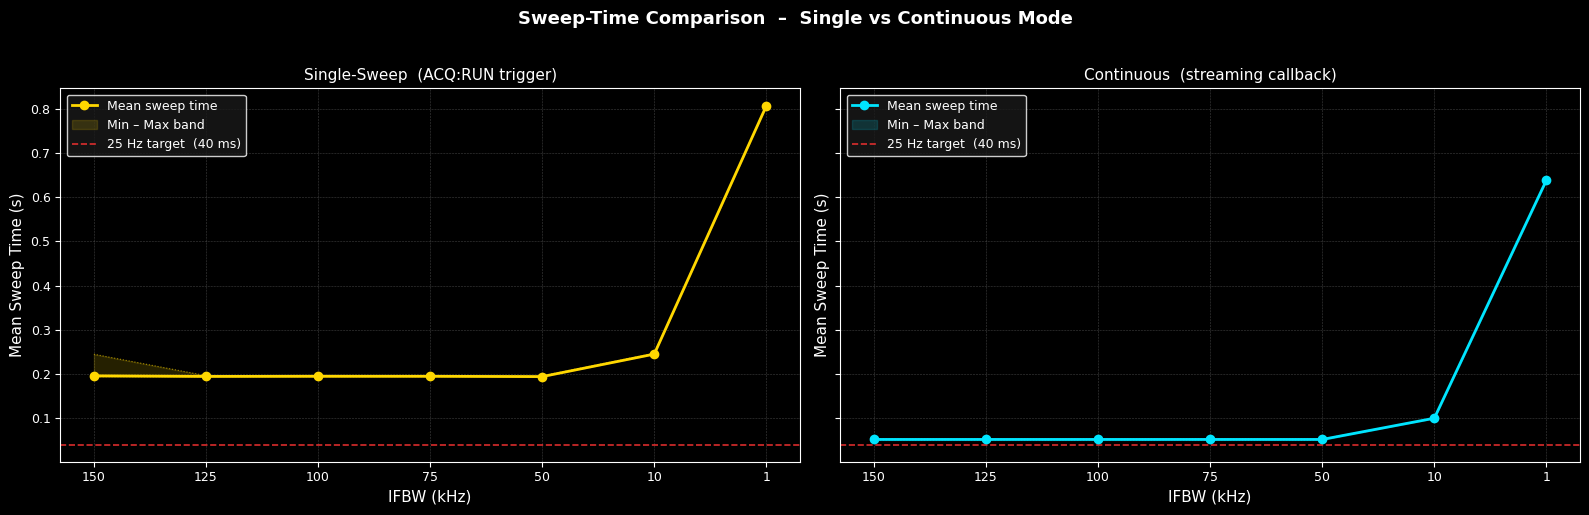

In [3]:
# ---------------------------------------------------------------------------
# Cell 4  --  Sweep-time comparison  (mean ± min/max band, per mode)
# ---------------------------------------------------------------------------
plt.style.use("dark_background")

# Align both DataFrames to the canonical IFBW order
def _align(df):
    """Return (mean_time, min_time, max_time) arrays aligned to IFBW_KHZS."""
    row_map = {int(r["IFBW (kHz)"]): r for _, r in df.iterrows()}
    mean = np.array([row_map[k]["Mean Time (s)"]  for k in IFBW_KHZS])
    mn   = np.array([row_map[k]["Min Time (s)"]   for k in IFBW_KHZS])
    mx   = np.array([row_map[k]["Max Time (s)"]   for k in IFBW_KHZS])
    return mean, mn, mx

s_mean, s_min, s_max = _align(df_single)
c_mean, c_min, c_max = _align(df_continuous)

x    = np.arange(len(IFBW_KHZS))
labels = [f"{k}" for k in IFBW_KHZS]

TARGET_TIME = 1.0 / 25.0   # 0.040 s  →  25 Hz

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
fig.patch.set_facecolor("black")
fig.suptitle("Sweep-Time Comparison  –  Single vs Continuous Mode",
             color="white", fontsize=13, fontweight="bold", y=1.02)

for ax, mode_label, mean, mn, mx, clr in [
        (axes[0], "Single-Sweep  (ACQ:RUN trigger)",  s_mean, s_min, s_max, COLOR_GOLD),
        (axes[1], "Continuous  (streaming callback)", c_mean, c_min, c_max, COLOR_CYAN)]:

    ax.set_facecolor("black")

    # Mean as a line with markers
    ax.plot(x, mean, color=clr, linewidth=2.0, marker="o", markersize=6,
            zorder=3, label="Mean sweep time")

    # Min / Max shaded band
    ax.fill_between(x, mn, mx, color=clr, alpha=0.15, label="Min – Max band")
    ax.plot(x, mn, color=clr, linewidth=0.8, linestyle=":", alpha=0.6)
    ax.plot(x, mx, color=clr, linewidth=0.8, linestyle=":", alpha=0.6)

    # 25 Hz target line
    ax.axhline(TARGET_TIME, color=COLOR_RED, linewidth=1.2, linestyle="--",
               alpha=0.85, label=f"25 Hz target  ({TARGET_TIME*1e3:.0f} ms)")

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_xlabel("IFBW (kHz)", color="white", fontsize=11)
    ax.set_ylabel("Mean Sweep Time (s)", color="white", fontsize=11)
    ax.set_title(mode_label, color="white", fontsize=11)
    ax.tick_params(colors="white", labelsize=9)
    ax.legend(fontsize=9, facecolor="#1a1a1a", edgecolor="white", labelcolor="white",
              loc="upper left")
    ax.grid(True, color="white", linestyle="--", linewidth=0.4, alpha=0.25)
    ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

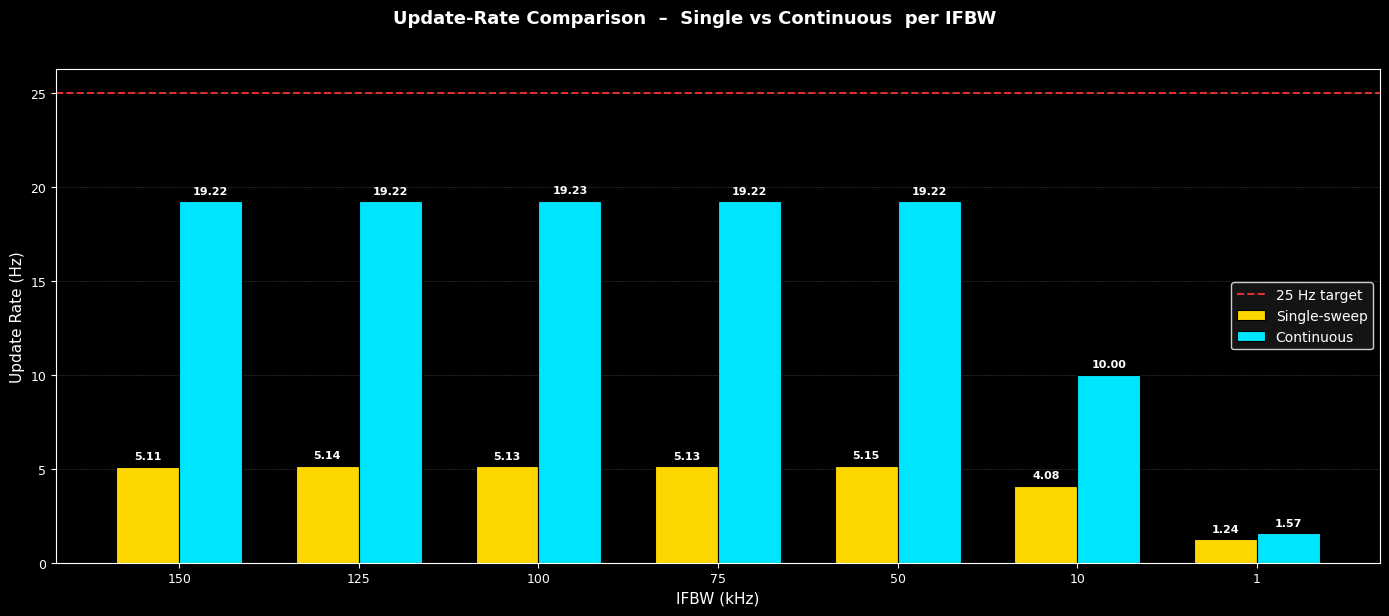

In [4]:
# ---------------------------------------------------------------------------
# Cell 5  --  Update-rate grouped bar chart  (single vs continuous)
# ---------------------------------------------------------------------------
plt.style.use("dark_background")

def _align_rate(df):
    row_map = {int(r["IFBW (kHz)"]): r for _, r in df.iterrows()}
    return np.array([row_map[k]["Rate (Hz)"] for k in IFBW_KHZS])

s_rate = _align_rate(df_single)
c_rate = _align_rate(df_continuous)

x       = np.arange(len(IFBW_KHZS))
width   = 0.35
labels  = [f"{k}" for k in IFBW_KHZS]

fig, ax = plt.subplots(figsize=(14, 6))
fig.patch.set_facecolor("black")
ax.set_facecolor("black")

bars_s = ax.bar(x - width / 2, s_rate, width, color=COLOR_GOLD,
                edgecolor="black", linewidth=0.8, label="Single-sweep")
bars_c = ax.bar(x + width / 2, c_rate, width, color=COLOR_CYAN,
                edgecolor="black", linewidth=0.8, label="Continuous")

# 25 Hz target
ax.axhline(25.0, color=COLOR_RED, linewidth=1.4, linestyle="--",
           alpha=0.9, label="25 Hz target", zorder=2)

# Annotate each bar with its value
for bars in (bars_s, bars_c):
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, h + 0.3,
                f"{h:.2f}", ha="center", va="bottom",
                color="white", fontsize=8, fontweight="bold")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("IFBW (kHz)", color="white", fontsize=11)
ax.set_ylabel("Update Rate (Hz)", color="white", fontsize=11)
ax.tick_params(colors="white", labelsize=9)
ax.legend(fontsize=10, facecolor="#1a1a1a", edgecolor="white", labelcolor="white")
ax.grid(True, axis="y", color="white", linestyle="--", linewidth=0.4, alpha=0.25)
ax.set_axisbelow(True)

fig.suptitle("Update-Rate Comparison  –  Single vs Continuous  per IFBW",
             color="white", fontsize=13, fontweight="bold", y=1.02)

plt.tight_layout()
plt.show()

  Loaded IFBW  150 kHz  –  single (300, 30), continuous (300, 30)
  Loaded IFBW  125 kHz  –  single (300, 30), continuous (300, 30)
  Loaded IFBW  100 kHz  –  single (300, 30), continuous (300, 30)
  Loaded IFBW   75 kHz  –  single (300, 30), continuous (300, 30)
  Loaded IFBW   50 kHz  –  single (300, 30), continuous (300, 30)
  Loaded IFBW   10 kHz  –  single (300, 30), continuous (300, 30)
  Loaded IFBW    1 kHz  –  single (300, 30), continuous (300, 30)


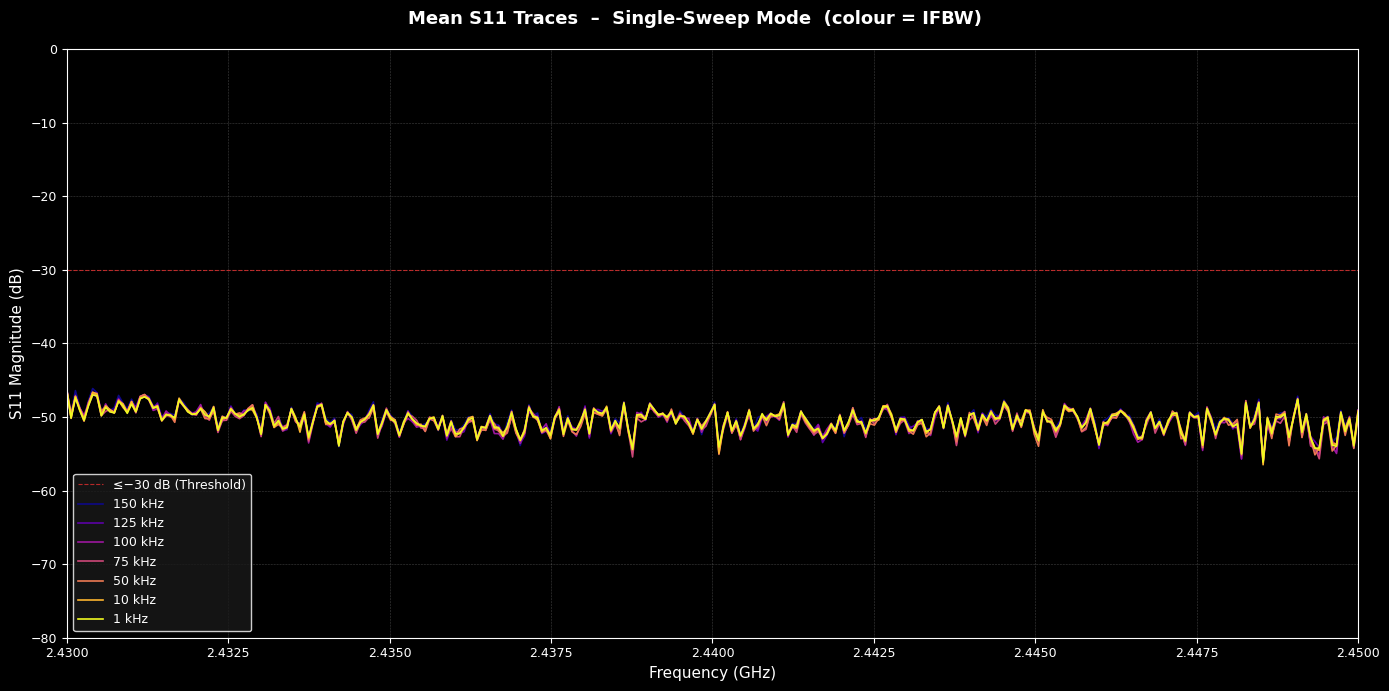

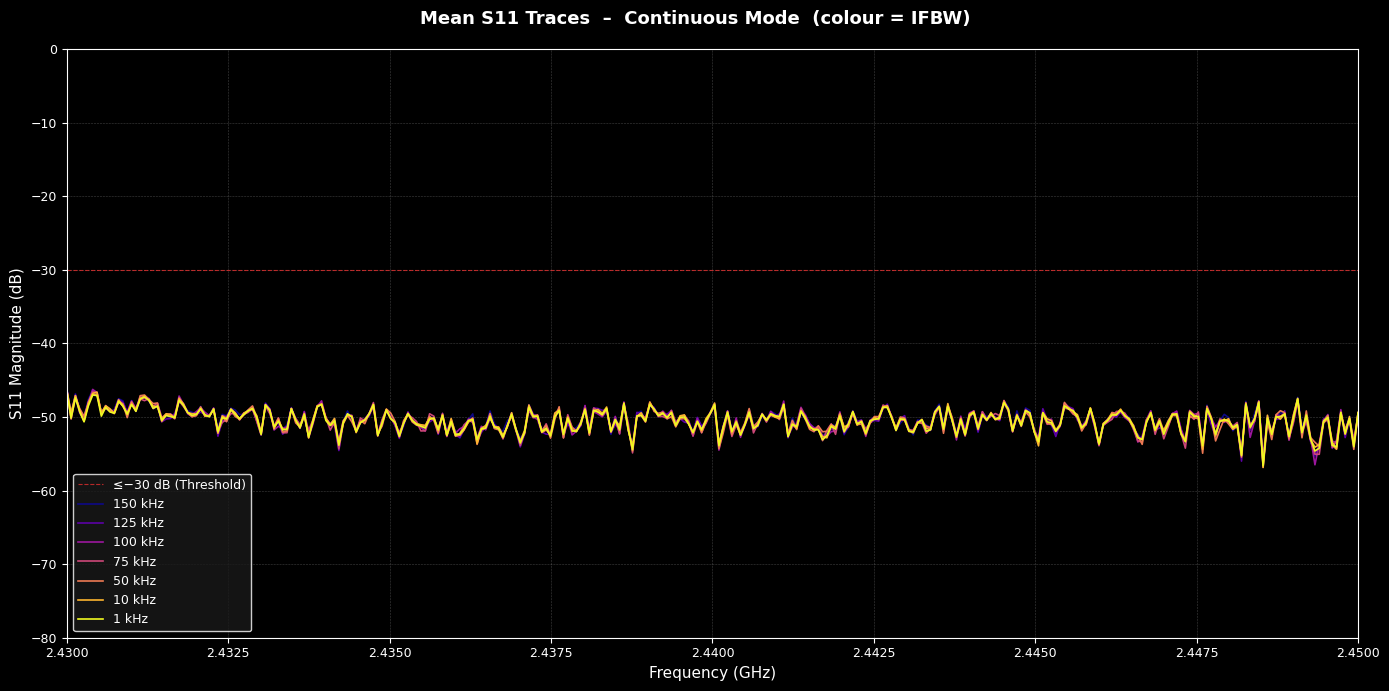

In [10]:
# ---------------------------------------------------------------------------
# Cell 6  --  Mean S11 overlay  (one panel per mode, coloured by IFBW)
# ---------------------------------------------------------------------------
plt.style.use("dark_background")

# ---------------------------------------------------------------------------
# Helper: extract (freq_hz, s11_matrix) from a per-IFBW sheet using pandas
# ---------------------------------------------------------------------------
def _load_s11_traces(xlsx_path: str, ifbw_khz: int):
    """Return (freq_hz: 1-D array, s11_dB: 2-D array [n_points x n_sweeps]).

    The per-IFBW sheet layout:
        Rows 1-9   – config block
        Row  10    – 'Timing' label
        Rows 11-41 – timing data (header + 30 sweeps)
        Row  42    – blank
        Row  43    – 'S11 Traces' label
        Row  44    – column headers  (Frequency (Hz), Sweep_1 S11 (dB), …)
        Rows 45-344– 300 frequency-point data rows
        Row  345   – blank
        Row  346   – 'Metrics' label
        Rows 347-348– noise / jitter

    pandas skiprows=43 (0-indexed) skips rows 1-43 (1-indexed),
    so header lands on row 44 and data starts at row 45.
    nrows=300 reads exactly the trace data.
    """
    sheet_name = f"IFBW_{ifbw_khz}kHz"
    df = pd.read_excel(xlsx_path, sheet_name=sheet_name,
                       engine="openpyxl", skiprows=43, nrows=300)
    freq_hz  = df.iloc[:, 0].to_numpy(dtype=np.float64)
    s11_mat  = df.iloc[:, 1:].to_numpy(dtype=np.float64)   # (300, n_sweeps)
    return freq_hz, s11_mat

# ---------------------------------------------------------------------------
# Pre-load all S11 data for both modes  (cached in dicts)
# ---------------------------------------------------------------------------
s11_single     = {}   # ifbw_khz  →  (freq_hz, s11_matrix)
s11_continuous = {}

for ifbw in IFBW_KHZS:
    s11_single[ifbw]     = _load_s11_traces(SINGLE_XLSX,     ifbw)
    s11_continuous[ifbw] = _load_s11_traces(CONTINUOUS_XLSX, ifbw)
    print(f"  Loaded IFBW {ifbw:>4d} kHz  –  "
          f"single {s11_single[ifbw][1].shape}, "
          f"continuous {s11_continuous[ifbw][1].shape}")

# ---------------------------------------------------------------------------
# Plot 1  –  Single-Sweep Mode
# ---------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 7))
fig.patch.set_facecolor("black")
ax.set_facecolor("black")

fig.suptitle("Mean S11 Traces  –  Single-Sweep Mode  (colour = IFBW)",
             color="white", fontsize=13, fontweight="bold", y=0.98)

# -30 dB threshold reference line
ax.axhline(-30.0, color="#FF3333", linewidth=0.8, linestyle="--", alpha=0.7,
           label="≤−30 dB (Threshold)")

for idx, ifbw in enumerate(IFBW_KHZS):
    freq_hz, s11_mat = s11_single[ifbw]
    freq_ghz = freq_hz / 1e9
    mean_s11 = np.mean(s11_mat, axis=1)

    ax.plot(freq_ghz, mean_s11, color=IFBW_COLORS[idx], linewidth=1.2,
            label=f"{ifbw} kHz")

ax.set_xlim(2.430, 2.450)
ax.set_ylim(bottom=-80, top=0)
ax.set_xlabel("Frequency (GHz)", color="white", fontsize=11)
ax.set_ylabel("S11 Magnitude (dB)", color="white", fontsize=11)
ax.tick_params(colors="white", labelsize=9)
ax.legend(loc="lower left", fontsize=9,
          facecolor="#1a1a1a", edgecolor="white", labelcolor="white")
ax.grid(True, color="white", linestyle="--", linewidth=0.4, alpha=0.25)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Plot 2  –  Continuous Mode
# ---------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 7))
fig.patch.set_facecolor("black")
ax.set_facecolor("black")

fig.suptitle("Mean S11 Traces  –  Continuous Mode  (colour = IFBW)",
             color="white", fontsize=13, fontweight="bold", y=0.98)

# -30 dB threshold reference line
ax.axhline(-30.0, color="#FF3333", linewidth=0.8, linestyle="--", alpha=0.7,
           label="≤−30 dB (Threshold)")

for idx, ifbw in enumerate(IFBW_KHZS):
    freq_hz, s11_mat = s11_continuous[ifbw]
    freq_ghz = freq_hz / 1e9
    mean_s11 = np.mean(s11_mat, axis=1)

    ax.plot(freq_ghz, mean_s11, color=IFBW_COLORS[idx], linewidth=1.2,
            label=f"{ifbw} kHz")

ax.set_xlim(2.430, 2.450)
ax.set_ylim(bottom=-80, top=0)
ax.set_xlabel("Frequency (GHz)", color="white", fontsize=11)
ax.set_ylabel("S11 Magnitude (dB)", color="white", fontsize=11)
ax.tick_params(colors="white", labelsize=9)
ax.legend(loc="lower left", fontsize=9,
          facecolor="#1a1a1a", edgecolor="white", labelcolor="white")
ax.grid(True, color="white", linestyle="--", linewidth=0.4, alpha=0.25)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

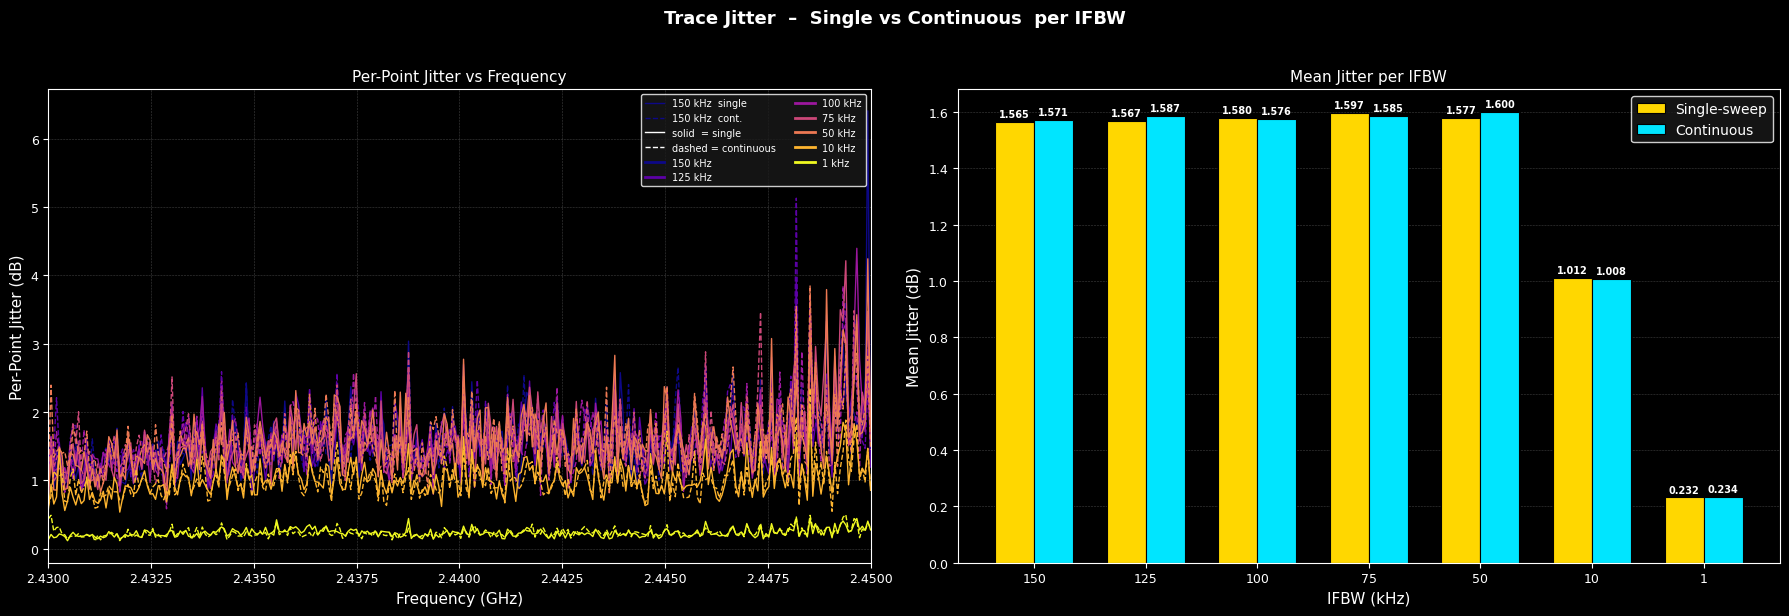

In [6]:
# ---------------------------------------------------------------------------
# Cell 7  --  Jitter analysis
#   Left panel  – per-point jitter (std, ddof=1) vs frequency
#                 single = solid, continuous = dashed, same colour per IFBW
#   Right panel – mean jitter per IFBW, grouped bars (single vs continuous)
# ---------------------------------------------------------------------------
plt.style.use("dark_background")

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.patch.set_facecolor("black")
fig.suptitle("Trace Jitter  –  Single vs Continuous  per IFBW",
             color="white", fontsize=13, fontweight="bold", y=1.02)

# ---------------------------------------------------------------------------
# Left panel  –  per-point jitter curves
# ---------------------------------------------------------------------------
ax = axes[0]
ax.set_facecolor("black")

mean_jitter_single     = []   # ordered by IFBW_KHZS
mean_jitter_continuous = []

for idx, ifbw in enumerate(IFBW_KHZS):
    freq_hz_s, s11_s = s11_single[ifbw]
    freq_hz_c, s11_c = s11_continuous[ifbw]

    jit_s = np.std(s11_s, axis=1, ddof=1)   # (300,)
    jit_c = np.std(s11_c, axis=1, ddof=1)

    mean_jitter_single.append(float(np.mean(jit_s)))
    mean_jitter_continuous.append(float(np.mean(jit_c)))

    freq_ghz = freq_hz_s / 1e9   # same for both modes

    ax.plot(freq_ghz, jit_s, color=IFBW_COLORS[idx], linewidth=1.0,
            linestyle="-",  label=f"{ifbw} kHz  single"    if idx == 0 else None)
    ax.plot(freq_ghz, jit_c, color=IFBW_COLORS[idx], linewidth=1.0,
            linestyle="--", label=f"{ifbw} kHz  cont."     if idx == 0 else None)

    # Only label the first IFBW to show the solid/dashed convention;
    # label every IFBW by colour in the legend below
    if idx == 0:
        ax.plot([], [], color="white", linewidth=1.0, linestyle="-",  label="solid  = single")
        ax.plot([], [], color="white", linewidth=1.0, linestyle="--", label="dashed = continuous")

# Add colour-only legend entries for each IFBW
for idx, ifbw in enumerate(IFBW_KHZS):
    ax.plot([], [], color=IFBW_COLORS[idx], linewidth=2.0, label=f"{ifbw} kHz")

ax.set_xlim(2.430, 2.450)
ax.set_xlabel("Frequency (GHz)", color="white", fontsize=11)
ax.set_ylabel("Per-Point Jitter (dB)", color="white", fontsize=11)
ax.set_title("Per-Point Jitter vs Frequency", color="white", fontsize=11)
ax.tick_params(colors="white", labelsize=9)
ax.legend(fontsize=7, facecolor="#1a1a1a", edgecolor="white", labelcolor="white",
          loc="upper right", ncol=2)
ax.grid(True, color="white", linestyle="--", linewidth=0.4, alpha=0.25)
ax.set_axisbelow(True)

# ---------------------------------------------------------------------------
# Right panel  –  mean jitter grouped bar chart
# ---------------------------------------------------------------------------
ax = axes[1]
ax.set_facecolor("black")

x     = np.arange(len(IFBW_KHZS))
width = 0.35
labels = [f"{k}" for k in IFBW_KHZS]

bars_s = ax.bar(x - width / 2, mean_jitter_single,     width,
                color=COLOR_GOLD, edgecolor="black", linewidth=0.8, label="Single-sweep")
bars_c = ax.bar(x + width / 2, mean_jitter_continuous, width,
                color=COLOR_CYAN, edgecolor="black", linewidth=0.8, label="Continuous")

# Annotate
for bars in (bars_s, bars_c):
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, h + 0.01,
                f"{h:.3f}", ha="center", va="bottom",
                color="white", fontsize=7, fontweight="bold")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("IFBW (kHz)", color="white", fontsize=11)
ax.set_ylabel("Mean Jitter (dB)", color="white", fontsize=11)
ax.set_title("Mean Jitter per IFBW", color="white", fontsize=11)
ax.tick_params(colors="white", labelsize=9)
ax.legend(fontsize=10, facecolor="#1a1a1a", edgecolor="white", labelcolor="white")
ax.grid(True, axis="y", color="white", linestyle="--", linewidth=0.4, alpha=0.25)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

In [7]:
# ---------------------------------------------------------------------------
# Cell 8  --  Summary comparison tables  (PrettyTable)
# ---------------------------------------------------------------------------

# ---------------------------------------------------------------------------
# Helper: build aligned lookup dicts from the two Summary DataFrames
# ---------------------------------------------------------------------------
def _row_map(df):
    return {int(r["IFBW (kHz)"]): r for _, r in df.iterrows()}

s_map = _row_map(df_single)
c_map = _row_map(df_continuous)

# ---------------------------------------------------------------------------
# Table 1: Full timing comparison
# ---------------------------------------------------------------------------
t1 = PrettyTable()
t1.field_names = ["IFBW (kHz)",
                  "Single Mean (s)", "Single Rate (Hz)",
                  "Cont. Mean (s)",  "Cont. Rate (Hz)"]

for ifbw in IFBW_KHZS:
    t1.add_row([
        f"{ifbw}",
        f"{s_map[ifbw]['Mean Time (s)']:.4f}",
        f"{s_map[ifbw]['Rate (Hz)']:.2f}",
        f"{c_map[ifbw]['Mean Time (s)']:.4f}",
        f"{c_map[ifbw]['Rate (Hz)']:.2f}"
    ])

print("Table 1  –  Timing Comparison")
print(t1)
print()

# ---------------------------------------------------------------------------
# Table 2: Ratios  (continuous / single)
# ---------------------------------------------------------------------------
t2 = PrettyTable()
t2.field_names = ["IFBW (kHz)", "Time Ratio (cont / single)",
                  "Rate Ratio (cont / single)"]

for ifbw in IFBW_KHZS:
    time_ratio = c_map[ifbw]["Mean Time (s)"] / s_map[ifbw]["Mean Time (s)"]
    rate_ratio = c_map[ifbw]["Rate (Hz)"]     / s_map[ifbw]["Rate (Hz)"]
    t2.add_row([
        f"{ifbw}",
        f"{time_ratio:.3f}x",
        f"{rate_ratio:.2f}x"
    ])

print("Table 2  –  Ratios  (continuous / single)")
print(t2)
print()

# ---------------------------------------------------------------------------
# Table 3: Jitter comparison  (using values computed in Cell 7)
# ---------------------------------------------------------------------------
t3 = PrettyTable()
t3.field_names = ["IFBW (kHz)", "Single Jitter (dB)",
                  "Cont. Jitter (dB)", "Jitter Ratio (cont / single)"]

for idx, ifbw in enumerate(IFBW_KHZS):
    js = mean_jitter_single[idx]
    jc = mean_jitter_continuous[idx]
    ratio = jc / js if js > 0 else float("inf")
    t3.add_row([
        f"{ifbw}",
        f"{js:.4f}",
        f"{jc:.4f}",
        f"{ratio:.3f}x"
    ])

print("Table 3  –  Jitter Comparison")
print(t3)
print()

# ---------------------------------------------------------------------------
# Table 4: Noise-floor comparison  (from Summary sheets)
# ---------------------------------------------------------------------------
t4 = PrettyTable()
t4.field_names = ["IFBW (kHz)", "Single Noise Floor (dB)", "Cont. Noise Floor (dB)"]

for ifbw in IFBW_KHZS:
    t4.add_row([
        f"{ifbw}",
        f"{s_map[ifbw]['Noise Floor (dB)']:.2f}",
        f"{c_map[ifbw]['Noise Floor (dB)']:.2f}"
    ])

print("Table 4  –  Noise Floor Comparison")
print(t4)

Table 1  –  Timing Comparison
+------------+-----------------+------------------+----------------+-----------------+
| IFBW (kHz) | Single Mean (s) | Single Rate (Hz) | Cont. Mean (s) | Cont. Rate (Hz) |
+------------+-----------------+------------------+----------------+-----------------+
|    150     |      0.1958     |       5.11       |     0.0520     |      19.22      |
|    125     |      0.1945     |       5.14       |     0.0520     |      19.22      |
|    100     |      0.1948     |       5.13       |     0.0520     |      19.23      |
|     75     |      0.1948     |       5.13       |     0.0520     |      19.22      |
|     50     |      0.1941     |       5.15       |     0.0520     |      19.22      |
|     10     |      0.2450     |       4.08       |     0.1000     |      10.00      |
|     1      |      0.8062     |       1.24       |     0.6381     |       1.57      |
+------------+-----------------+------------------+----------------+-----------------+

Table 2  –  

## Conclusions  –  Single-Sweep vs Continuous-Sweep Mode

### 1. Continuous mode is faster at every IFBW — no crossover exists

At the five wide IFBWs (150–50 kHz) continuous mode is a consistent **3.7– 3.8x faster** (52 ms vs 195 ms).
The speed advantage narrows at 10 kHz (2.45x) and 1 kHz (1.27x), but continuous mode never falls behind single mode at any IFBW value tested.

The reason the gap shrinks at narrow IFBWs is straightforward: both modes are gated by the same raw ADC acquisition time, which grows linearly with 1/IFBW. At 1 kHz the acquisition itself dominates the total cycle time, so the GUI-dispatch overhead that separates the two modes (roughly 140 ms for single, roughly 0 ms for continuous) becomes a smaller fraction of the total.

### 2. The 25 Hz target is not met by either mode

| Mode | Best Rate | Best IFBW |
|---|---|---|
| Single-sweep | 5.15 Hz | 50 kHz |
| Continuous | 19.23 Hz | 100 kHz |

Continuous mode at wide IFBWs reaches **19.2 Hz** — the closest either mode gets to the 25 Hz target.
The shortfall (5.8 Hz, or 23 %) is inside the LibreVNA-GUI streaming pipeline: the calibrated-data stream on port 19001 adds roughly 12 ms of latency per sweep beyond the raw 30 ms ADC floor.

Single-sweep mode is capped at **5.1 Hz** regardless of IFBW (for 50–150 kHz) because the ACQ:RUN → ACQ:FIN? round-trip through the GUI imposes a fixed ~195 ms overhead per sweep.

### 3. Jitter is statistically identical between modes

Across all seven IFBWs the jitter ratio (continuous / single) is **0.99–1.01x** — well within measurement noise.
This is the expected result: both modes read from the same ADC and apply the same calibration data; the only difference is the transport path to the host. The transport path does not affect measurement repeatability.

The jitter itself follows the textbook IFBW dependence:

| IFBW | Mean Jitter (dB) |
|---|---|
| 150–50 kHz | ~1.58 |
| 10 kHz | ~1.01 |
| 1 kHz | ~0.23 |

Narrowing the IFBW from 150 kHz to 1 kHz reduces jitter by **6.8x**.

### 4. Noise floor is IFBW-independent and mode-independent

Both modes produce a noise floor in the range **-50.3 to -50.6 dB** across all IFBWs.
This value reflects the SOLT calibration residual at the calibrated 50 Ohm load, not the receiver noise bandwidth.
A re-test with an open or short standard would isolate the true raw receiver noise floor.

### 5. Speed vs measurement-quality trade-off

| Goal | Recommended setting |
|---|---|
| Maximum update rate | Continuous mode, IFBW 50–150 kHz → 19.2 Hz |
| Maximum trace repeatability | Either mode, IFBW 1 kHz → 0.23 dB jitter (but only 1.2–1.6 Hz) |
| Balanced (rate + quality) | Continuous mode, IFBW 10 kHz → 10 Hz, 1.01 dB jitter |

### 6. Recommendation — USB direct protocol

Neither SCPI path reaches 25 Hz.  The theoretical USB direct path delivers ~33 Hz (raw ADC floor for 300 pts at 10 k pts/s is 30 ms; USB overhead is ~0 ms).  Implementation requires:

1. Host-side USB device driver (VID `0x1209`, PID `0x4121`).
2. `SweepSettings` packet (type 2) with SO=0 to enter auto-loop mode.
3. Host-side S-parameter assembly from raw receiver data (`VNADatapoint`, type 27).
4. Host-side SOLT calibration application using the existing `SOLT_1_2_43G-2_45G_300pt.cal` coefficients.

The USB path is fully documented in `markdown/20260205/part2-continuous-sweep-implementation.md` section 7.11.